<a href="https://colab.research.google.com/github/tahmidawal/DeepLearningClass/blob/main/8_1D_CNN_activity_recognition_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright
<pre>
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved

</pre>

In this notebook, we will classify human activities based on smartphone accelerometer and gyroscope data. The corresponding Human Activity Recognition Using Smartphones Data Set is delivered by UCI Machine Learning Repository, for more information [please visit the site](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

## 1. Data acquisition
Lets download and unpack the data.

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

--2023-04-12 18:37:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  16.7MB/s    in 4.5s    

2023-04-12 18:37:19 (13.1 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [2]:
!unzip "UCI HAR Dataset.zip" > null

## 2. Imports
In this notebook we will need the following packages.

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Loading the data
The following functions will load the training and test data from the unpacked dataset.

In [4]:
# this function loads a single file (input or output)
def load_file(filepath):
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
  return df.values

# this function loads a set of files into a Numpy array with a shape of [samples, timesteps, features]
def load_group(filenames, prefix=''):
  loaded = list()
  for name in filenames:
    data = load_file(prefix + name)
    loaded.append(data)
    # stack group so that features are the 3rd dimension
  loaded = np.dstack(loaded)
  return loaded

 # load inputs and outputs from a directory
def load_XY(group, path):
  filepath = path + group + '/Inertial Signals/'
  filenames = list()
  filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt'] + \
               ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt'] + \
               ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
  # inputs
  X = load_group(filenames, filepath)
  # output (class)
  Y = load_file(path + group + '/y_'+group+'.txt')
  return X, Y

# load the dataset, returns train and test X and y elements
def load_dataset(path='UCI HAR Dataset/'):
  # load all train
  X_train, Y_train = load_XY('train', path)
  X_test,  Y_test  = load_XY('test', path)
  Y_train = to_categorical(Y_train - 1 ) # we need -1 to scale the categories between 0..5 (from 1..6)
  Y_test  = to_categorical(Y_test - 1 ) # we need -1 to scale the categories between 0..5 (from 1..6)
  return X_train, Y_train, X_test, Y_test

In [5]:
X_train, Y_train, X_test, Y_test = load_dataset()

In [6]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((7352, 128, 9), (7352, 6), (2947, 128, 9), (2947, 6))

In [7]:
Y_train[0],

(array([0., 0., 0., 0., 1., 0.], dtype=float32),)

In [8]:
X_train

array([[[ 1.012817e+00, -1.232167e-01,  1.029341e-01, ...,
          3.019122e-02,  6.601362e-02,  2.285864e-02],
        [ 1.022833e+00, -1.268756e-01,  1.056872e-01, ...,
          4.371071e-02,  4.269897e-02,  1.031572e-02],
        [ 1.022028e+00, -1.240037e-01,  1.021025e-01, ...,
          3.568780e-02,  7.485018e-02,  1.324969e-02],
        ...,
        [ 1.018445e+00, -1.240696e-01,  1.003852e-01, ...,
          3.985177e-02,  1.909445e-03, -2.170124e-03],
        [ 1.019372e+00, -1.227451e-01,  9.987355e-02, ...,
          3.744932e-02, -7.982483e-05, -5.642633e-03],
        [ 1.021171e+00, -1.213260e-01,  9.498741e-02, ...,
          2.881781e-02, -3.771800e-05, -1.446006e-03]],

       [[ 1.018851e+00, -1.239760e-01,  9.792958e-02, ...,
          1.711106e-02,  6.122797e-03,  1.226815e-02],
        [ 1.022380e+00, -1.268078e-01,  9.935086e-02, ...,
          2.417851e-02,  9.710357e-03,  1.614958e-02],
        [ 1.020781e+00, -1.277862e-01,  9.811381e-02, ...,
          3.02

## 3.1. Data exploration: target variable - exercise 1
Let's check how many data instances there are for each class:

In [10]:
Y_classes = np.argmax(Y_train, axis=1)
print("No. of instance belong to class 0:", np.sum(Y_classes == 0))
print("No. of instance belong to class 1:", np.sum(Y_classes == 1))
print("No. of instance belong to class 2:", np.sum(Y_classes == 2))
print("No. of instance belong to class 3:", np.sum(Y_classes == 3))
print("No. of instance belong to class 4:", np.sum(Y_classes == 4))
print("No. of instance belong to class 5:", np.sum(Y_classes == 5))

No. of instance belong to class 0: 1226
No. of instance belong to class 1: 1073
No. of instance belong to class 2: 986
No. of instance belong to class 3: 1286
No. of instance belong to class 4: 1374
No. of instance belong to class 5: 1407


You can doublecheck your calculations by plotting the histogram of the target variables: 

<Axes: ylabel='Count'>

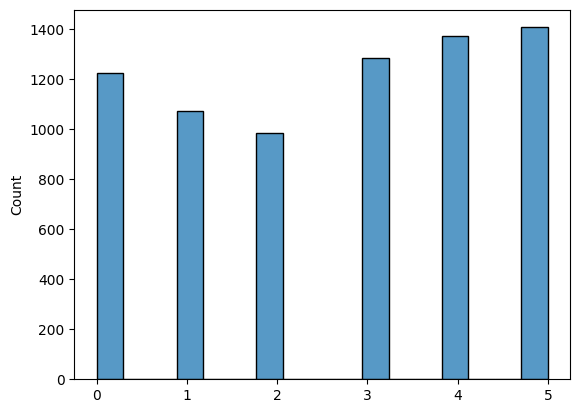

In [11]:
sns.histplot(np.argmax(Y_train,axis=1))

## 3.2. Data exploration: input variables - exercise 2
And now let's select one instance from each class and plot the corresponding timeseries:

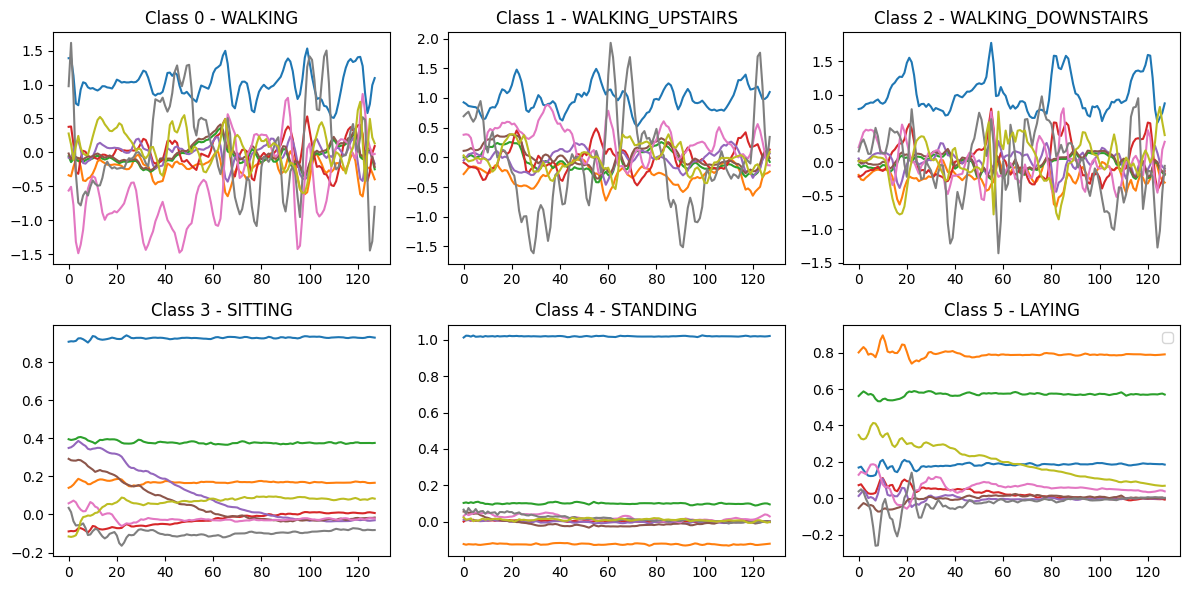

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

for i in range(2):  # row
    for k in range(3):  # column
        class_no = i * 3 + k
        instance_index = np.where(Y_classes == class_no)[0][0]  # get the index of one instance for the current class
        for l in range(X_train.shape[2]):  # dimensions to be displayed
            axs[i, k].plot(X_train[instance_index, :, l])  # select the input sequence of one instance from class #class_no
        axs[i, k].title.set_text("Class " + str(class_no) + " - " + labels[class_no])

plt.legend()
plt.tight_layout()
plt.show()

## 4. Model definition and training - exercise 3

Let's define and train a 1D convolutional neural network, with the multidimensional timeseries as inputs, and the class in one-hot encoding as output. 

This time your task is to correct the code below and achieve higher than 90% validation accuracy and test accuracy. The test accuracy is calculated in section 5. 
Currently, **there are many errors (both syntactical and theroetical) in the model definition, compile and fit parts**, that should be fixed to achieve the goal. Don't change the number of layers and the layer types, and validation_split, just the other hyperparameters. There are several good solutions!

Hints: 
* use narrow and deep Conv1D kernels
* use standard activation functions for the inner layers (e.g. relu, sigmoid, tanh) with the corresponding initialization method
* use the appropriate activation function the output and the corresponding loss function (which is aligned with the classification task)
* use regularization, but not too agressive
* use standard optimizers
* train in mini-batches

In [19]:
nb_filter       = 64   # number of filter/kernels in the convolutional layers
filter_length   = 4  # length of the filter/kernel in the convolutional layers
window_size     = X_train.shape[1] # the window size defined by the dataset
nb_features     = X_train.shape[2] # the number of features of the input data
nb_outputs      = Y_train.shape[1] # the number of outputs (defined by the target data)

In [20]:
model = Sequential()
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_features)))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_outputs, activation='softmax'))

Compiling the model with the appropriate loss function for multiclass classification.

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 125, 64)           2368      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 64)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 59, 64)            16448     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 29, 64)           0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 29, 64)           

In [33]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor="validation_loss")

And now we run the training:

In [35]:
model.fit(X_train, Y_train, 
          epochs=100, batch_size=32, 
          validation_split=0.2, # don't change the validation split
          callbacks=[es],
          verbose=2)

Epoch 1/100


184/184 - 1s - loss: 0.0305 - accuracy: 0.9884 - val_loss: 10.8728 - val_accuracy: 0.9048 - 1s/epoch - 8ms/step
Epoch 2/100


184/184 - 1s - loss: 0.0268 - accuracy: 0.9900 - val_loss: 12.5364 - val_accuracy: 0.9014 - 1s/epoch - 6ms/step
Epoch 3/100


184/184 - 1s - loss: 0.0170 - accuracy: 0.9912 - val_loss: 12.4661 - val_accuracy: 0.9048 - 959ms/epoch - 5ms/step
Epoch 4/100


184/184 - 1s - loss: 0.0212 - accuracy: 0.9908 - val_loss: 12.6563 - val_accuracy: 0.8906 - 942ms/epoch - 5ms/step
Epoch 5/100


184/184 - 1s - loss: 0.0233 - accuracy: 0.9903 - val_loss: 11.9265 - val_accuracy: 0.8810 - 957ms/epoch - 5ms/step
Epoch 6/100


184/184 - 1s - loss: 0.0262 - accuracy: 0.9912 - val_loss: 11.5120 - val_accuracy: 0.8926 - 945ms/epoch - 5ms/step
Epoch 7/100


184/184 - 1s - loss: 0.0500 - accuracy: 0.9895 - val_loss: 11.6150 - val_accuracy: 0.9007 - 1s/epoch - 6ms/step
Epoch 8/100


184/184 - 1s - loss: 0.0355 - accuracy: 0.9905 - val_loss: 10.6883 - val_accuracy: 0.9048 - 1s/epoch - 6ms/step
Epoch 9/100


184/184 - 1s - loss: 0.0287 - accuracy: 0.9896 - val_loss: 10.6929 - val_accuracy: 0.8946 - 839ms/epoch - 5ms/step
Epoch 10/100


184/184 - 1s - loss: 0.0303 - accuracy: 0.9884 - val_loss: 12.8017 - val_accuracy: 0.8838 - 851ms/epoch - 5ms/step
Epoch 11/100


184/184 - 1s - loss: 0.0210 - accuracy: 0.9905 - val_loss: 11.4538 - val_accuracy: 0.8810 - 956ms/epoch - 5ms/step
Epoch 12/100


184/184 - 1s - loss: 0.0190 - accuracy: 0.9900 - val_loss: 11.8298 - val_accuracy: 0.9048 - 974ms/epoch - 5ms/step
Epoch 13/100


184/184 - 1s - loss: 0.0207 - accuracy: 0.9927 - val_loss: 10.5329 - val_accuracy: 0.8817 - 889ms/epoch - 5ms/step
Epoch 14/100


184/184 - 1s - loss: 0.0520 - accuracy: 0.9895 - val_loss: 8.2177 - val_accuracy: 0.9041 - 857ms/epoch - 5ms/step
Epoch 15/100


184/184 - 1s - loss: 0.0278 - accuracy: 0.9883 - val_loss: 7.6491 - val_accuracy: 0.9007 - 870ms/epoch - 5ms/step
Epoch 16/100


184/184 - 1s - loss: 0.0549 - accuracy: 0.9920 - val_loss: 7.1559 - val_accuracy: 0.8878 - 843ms/epoch - 5ms/step
Epoch 17/100


184/184 - 1s - loss: 0.0215 - accuracy: 0.9898 - val_loss: 7.0639 - val_accuracy: 0.8973 - 956ms/epoch - 5ms/step
Epoch 18/100


184/184 - 1s - loss: 0.0297 - accuracy: 0.9893 - val_loss: 7.5535 - val_accuracy: 0.8953 - 879ms/epoch - 5ms/step
Epoch 19/100


184/184 - 1s - loss: 0.0185 - accuracy: 0.9906 - val_loss: 6.9986 - val_accuracy: 0.8912 - 1s/epoch - 7ms/step
Epoch 20/100


184/184 - 1s - loss: 0.0278 - accuracy: 0.9900 - val_loss: 7.6896 - val_accuracy: 0.8912 - 1s/epoch - 7ms/step
Epoch 21/100


184/184 - 1s - loss: 0.0191 - accuracy: 0.9896 - val_loss: 7.9209 - val_accuracy: 0.8933 - 898ms/epoch - 5ms/step
Epoch 22/100


184/184 - 1s - loss: 0.0342 - accuracy: 0.9891 - val_loss: 7.9399 - val_accuracy: 0.9014 - 889ms/epoch - 5ms/step
Epoch 23/100


184/184 - 1s - loss: 0.0250 - accuracy: 0.9900 - val_loss: 6.4758 - val_accuracy: 0.9021 - 882ms/epoch - 5ms/step
Epoch 24/100


184/184 - 1s - loss: 0.0371 - accuracy: 0.9898 - val_loss: 13.0296 - val_accuracy: 0.9048 - 980ms/epoch - 5ms/step
Epoch 25/100


184/184 - 1s - loss: 0.0817 - accuracy: 0.9917 - val_loss: 14.5700 - val_accuracy: 0.8906 - 865ms/epoch - 5ms/step
Epoch 26/100


184/184 - 1s - loss: 0.0227 - accuracy: 0.9905 - val_loss: 14.5814 - val_accuracy: 0.8946 - 838ms/epoch - 5ms/step
Epoch 27/100


184/184 - 1s - loss: 0.0355 - accuracy: 0.9901 - val_loss: 11.9254 - val_accuracy: 0.8783 - 844ms/epoch - 5ms/step
Epoch 28/100


184/184 - 1s - loss: 0.0300 - accuracy: 0.9874 - val_loss: 14.5404 - val_accuracy: 0.9035 - 864ms/epoch - 5ms/step
Epoch 29/100


184/184 - 1s - loss: 0.0261 - accuracy: 0.9901 - val_loss: 15.5019 - val_accuracy: 0.8967 - 837ms/epoch - 5ms/step
Epoch 30/100


184/184 - 1s - loss: 0.0244 - accuracy: 0.9925 - val_loss: 15.4264 - val_accuracy: 0.9007 - 952ms/epoch - 5ms/step
Epoch 31/100


184/184 - 1s - loss: 0.0449 - accuracy: 0.9901 - val_loss: 14.0520 - val_accuracy: 0.9014 - 845ms/epoch - 5ms/step
Epoch 32/100


184/184 - 1s - loss: 0.0317 - accuracy: 0.9896 - val_loss: 12.9000 - val_accuracy: 0.8987 - 1s/epoch - 6ms/step
Epoch 33/100


184/184 - 2s - loss: 0.0200 - accuracy: 0.9917 - val_loss: 15.2134 - val_accuracy: 0.8967 - 2s/epoch - 8ms/step
Epoch 34/100


184/184 - 1s - loss: 0.0228 - accuracy: 0.9908 - val_loss: 14.1457 - val_accuracy: 0.9035 - 834ms/epoch - 5ms/step
Epoch 35/100


184/184 - 1s - loss: 0.0376 - accuracy: 0.9888 - val_loss: 9.1525 - val_accuracy: 0.9041 - 839ms/epoch - 5ms/step
Epoch 36/100


184/184 - 1s - loss: 0.0176 - accuracy: 0.9918 - val_loss: 9.4380 - val_accuracy: 0.8926 - 871ms/epoch - 5ms/step
Epoch 37/100


184/184 - 1s - loss: 0.0175 - accuracy: 0.9913 - val_loss: 9.8684 - val_accuracy: 0.9014 - 934ms/epoch - 5ms/step
Epoch 38/100


184/184 - 1s - loss: 0.0252 - accuracy: 0.9913 - val_loss: 8.4485 - val_accuracy: 0.9014 - 938ms/epoch - 5ms/step
Epoch 39/100


184/184 - 1s - loss: 0.0367 - accuracy: 0.9876 - val_loss: 6.6497 - val_accuracy: 0.9041 - 944ms/epoch - 5ms/step
Epoch 40/100


184/184 - 1s - loss: 0.0248 - accuracy: 0.9900 - val_loss: 6.4774 - val_accuracy: 0.8844 - 967ms/epoch - 5ms/step
Epoch 41/100


184/184 - 1s - loss: 0.0206 - accuracy: 0.9912 - val_loss: 7.1672 - val_accuracy: 0.8926 - 833ms/epoch - 5ms/step
Epoch 42/100


184/184 - 1s - loss: 0.0135 - accuracy: 0.9930 - val_loss: 5.8718 - val_accuracy: 0.8912 - 960ms/epoch - 5ms/step
Epoch 43/100


184/184 - 1s - loss: 0.0351 - accuracy: 0.9886 - val_loss: 5.9094 - val_accuracy: 0.8967 - 857ms/epoch - 5ms/step
Epoch 44/100


184/184 - 1s - loss: 0.0315 - accuracy: 0.9906 - val_loss: 5.8767 - val_accuracy: 0.8973 - 867ms/epoch - 5ms/step
Epoch 45/100


184/184 - 2s - loss: 0.0171 - accuracy: 0.9913 - val_loss: 6.3294 - val_accuracy: 0.9028 - 2s/epoch - 8ms/step
Epoch 46/100


184/184 - 1s - loss: 0.0298 - accuracy: 0.9913 - val_loss: 8.0739 - val_accuracy: 0.8844 - 1s/epoch - 6ms/step
Epoch 47/100


184/184 - 1s - loss: 0.0282 - accuracy: 0.9910 - val_loss: 5.3926 - val_accuracy: 0.8872 - 840ms/epoch - 5ms/step
Epoch 48/100


184/184 - 1s - loss: 0.0194 - accuracy: 0.9906 - val_loss: 6.0798 - val_accuracy: 0.8960 - 950ms/epoch - 5ms/step
Epoch 49/100


184/184 - 1s - loss: 0.0390 - accuracy: 0.9861 - val_loss: 4.2784 - val_accuracy: 0.8939 - 967ms/epoch - 5ms/step
Epoch 50/100


184/184 - 1s - loss: 0.0209 - accuracy: 0.9895 - val_loss: 5.1403 - val_accuracy: 0.9028 - 959ms/epoch - 5ms/step
Epoch 51/100


184/184 - 1s - loss: 0.0160 - accuracy: 0.9925 - val_loss: 5.2224 - val_accuracy: 0.9048 - 848ms/epoch - 5ms/step
Epoch 52/100


184/184 - 1s - loss: 0.0227 - accuracy: 0.9910 - val_loss: 5.5274 - val_accuracy: 0.9041 - 844ms/epoch - 5ms/step
Epoch 53/100


184/184 - 1s - loss: 0.0193 - accuracy: 0.9929 - val_loss: 5.6410 - val_accuracy: 0.9014 - 955ms/epoch - 5ms/step
Epoch 54/100


184/184 - 1s - loss: 0.0290 - accuracy: 0.9908 - val_loss: 7.6229 - val_accuracy: 0.8838 - 935ms/epoch - 5ms/step
Epoch 55/100


184/184 - 1s - loss: 0.0318 - accuracy: 0.9900 - val_loss: 7.3492 - val_accuracy: 0.8912 - 840ms/epoch - 5ms/step
Epoch 56/100


184/184 - 1s - loss: 0.0187 - accuracy: 0.9903 - val_loss: 6.4537 - val_accuracy: 0.9007 - 860ms/epoch - 5ms/step
Epoch 57/100


184/184 - 1s - loss: 0.0430 - accuracy: 0.9908 - val_loss: 5.4595 - val_accuracy: 0.8885 - 1s/epoch - 6ms/step
Epoch 58/100


184/184 - 1s - loss: 0.0297 - accuracy: 0.9896 - val_loss: 6.0348 - val_accuracy: 0.9021 - 1s/epoch - 7ms/step
Epoch 59/100


184/184 - 1s - loss: 0.0257 - accuracy: 0.9895 - val_loss: 6.0165 - val_accuracy: 0.9035 - 903ms/epoch - 5ms/step
Epoch 60/100


184/184 - 1s - loss: 0.0244 - accuracy: 0.9927 - val_loss: 6.5231 - val_accuracy: 0.9028 - 845ms/epoch - 5ms/step
Epoch 61/100


184/184 - 1s - loss: 0.0273 - accuracy: 0.9905 - val_loss: 5.4215 - val_accuracy: 0.9048 - 956ms/epoch - 5ms/step
Epoch 62/100


184/184 - 1s - loss: 0.0336 - accuracy: 0.9908 - val_loss: 4.6865 - val_accuracy: 0.9014 - 846ms/epoch - 5ms/step
Epoch 63/100


184/184 - 1s - loss: 0.0523 - accuracy: 0.9898 - val_loss: 4.2791 - val_accuracy: 0.9007 - 845ms/epoch - 5ms/step
Epoch 64/100


184/184 - 1s - loss: 0.0178 - accuracy: 0.9918 - val_loss: 5.1453 - val_accuracy: 0.9028 - 941ms/epoch - 5ms/step
Epoch 65/100


184/184 - 1s - loss: 0.0216 - accuracy: 0.9912 - val_loss: 5.6052 - val_accuracy: 0.9021 - 948ms/epoch - 5ms/step
Epoch 66/100


184/184 - 1s - loss: 0.0190 - accuracy: 0.9915 - val_loss: 6.1787 - val_accuracy: 0.8946 - 850ms/epoch - 5ms/step
Epoch 67/100


184/184 - 1s - loss: 0.0195 - accuracy: 0.9912 - val_loss: 5.7125 - val_accuracy: 0.8933 - 947ms/epoch - 5ms/step
Epoch 68/100


184/184 - 1s - loss: 0.0390 - accuracy: 0.9896 - val_loss: 9.1255 - val_accuracy: 0.9041 - 841ms/epoch - 5ms/step
Epoch 69/100


184/184 - 1s - loss: 0.0241 - accuracy: 0.9900 - val_loss: 9.2514 - val_accuracy: 0.9062 - 944ms/epoch - 5ms/step
Epoch 70/100


184/184 - 1s - loss: 0.0385 - accuracy: 0.9869 - val_loss: 7.3495 - val_accuracy: 0.9021 - 1s/epoch - 6ms/step
Epoch 71/100


184/184 - 1s - loss: 0.0328 - accuracy: 0.9896 - val_loss: 10.0615 - val_accuracy: 0.8953 - 1s/epoch - 8ms/step
Epoch 72/100


184/184 - 1s - loss: 0.0192 - accuracy: 0.9920 - val_loss: 10.0985 - val_accuracy: 0.9035 - 870ms/epoch - 5ms/step
Epoch 73/100


184/184 - 1s - loss: 0.0257 - accuracy: 0.9927 - val_loss: 12.7973 - val_accuracy: 0.9048 - 937ms/epoch - 5ms/step
Epoch 74/100


184/184 - 1s - loss: 0.0857 - accuracy: 0.9854 - val_loss: 7.8482 - val_accuracy: 0.8885 - 936ms/epoch - 5ms/step
Epoch 75/100


184/184 - 1s - loss: 0.0993 - accuracy: 0.9872 - val_loss: 9.3603 - val_accuracy: 0.8946 - 843ms/epoch - 5ms/step
Epoch 76/100


184/184 - 1s - loss: 0.0785 - accuracy: 0.9896 - val_loss: 8.8057 - val_accuracy: 0.8749 - 856ms/epoch - 5ms/step
Epoch 77/100


184/184 - 1s - loss: 0.0428 - accuracy: 0.9884 - val_loss: 9.2900 - val_accuracy: 0.8770 - 953ms/epoch - 5ms/step
Epoch 78/100


184/184 - 1s - loss: 0.0365 - accuracy: 0.9912 - val_loss: 10.8825 - val_accuracy: 0.8790 - 842ms/epoch - 5ms/step
Epoch 79/100


184/184 - 1s - loss: 0.0180 - accuracy: 0.9913 - val_loss: 10.6376 - val_accuracy: 0.8980 - 956ms/epoch - 5ms/step
Epoch 80/100


184/184 - 1s - loss: 0.0341 - accuracy: 0.9884 - val_loss: 10.3017 - val_accuracy: 0.8987 - 876ms/epoch - 5ms/step
Epoch 81/100


184/184 - 1s - loss: 0.0229 - accuracy: 0.9905 - val_loss: 8.9185 - val_accuracy: 0.8980 - 945ms/epoch - 5ms/step
Epoch 82/100


184/184 - 1s - loss: 0.0199 - accuracy: 0.9910 - val_loss: 8.4135 - val_accuracy: 0.8994 - 994ms/epoch - 5ms/step
Epoch 83/100


184/184 - 1s - loss: 0.0468 - accuracy: 0.9898 - val_loss: 8.2076 - val_accuracy: 0.9021 - 1s/epoch - 6ms/step
Epoch 84/100


184/184 - 1s - loss: 0.0271 - accuracy: 0.9905 - val_loss: 6.9151 - val_accuracy: 0.9035 - 1s/epoch - 6ms/step
Epoch 85/100


184/184 - 1s - loss: 0.0174 - accuracy: 0.9917 - val_loss: 7.1525 - val_accuracy: 0.9028 - 873ms/epoch - 5ms/step
Epoch 86/100


184/184 - 1s - loss: 0.0265 - accuracy: 0.9915 - val_loss: 7.2798 - val_accuracy: 0.8763 - 859ms/epoch - 5ms/step
Epoch 87/100


184/184 - 1s - loss: 0.0168 - accuracy: 0.9922 - val_loss: 6.7280 - val_accuracy: 0.8892 - 859ms/epoch - 5ms/step
Epoch 88/100


184/184 - 1s - loss: 0.0308 - accuracy: 0.9879 - val_loss: 8.4281 - val_accuracy: 0.8729 - 938ms/epoch - 5ms/step
Epoch 89/100


184/184 - 1s - loss: 0.0417 - accuracy: 0.9898 - val_loss: 10.7885 - val_accuracy: 0.8912 - 935ms/epoch - 5ms/step
Epoch 90/100


184/184 - 1s - loss: 0.0209 - accuracy: 0.9900 - val_loss: 9.4448 - val_accuracy: 0.8946 - 947ms/epoch - 5ms/step
Epoch 91/100


184/184 - 1s - loss: 0.0426 - accuracy: 0.9908 - val_loss: 10.1645 - val_accuracy: 0.9014 - 955ms/epoch - 5ms/step
Epoch 92/100


184/184 - 1s - loss: 0.0220 - accuracy: 0.9905 - val_loss: 10.6172 - val_accuracy: 0.8899 - 951ms/epoch - 5ms/step
Epoch 93/100


184/184 - 1s - loss: 0.0354 - accuracy: 0.9906 - val_loss: 7.7384 - val_accuracy: 0.9014 - 948ms/epoch - 5ms/step
Epoch 94/100


184/184 - 1s - loss: 0.0197 - accuracy: 0.9906 - val_loss: 10.9135 - val_accuracy: 0.8994 - 957ms/epoch - 5ms/step
Epoch 95/100


184/184 - 1s - loss: 0.0404 - accuracy: 0.9900 - val_loss: 12.9416 - val_accuracy: 0.8967 - 1s/epoch - 8ms/step
Epoch 96/100


184/184 - 1s - loss: 0.0393 - accuracy: 0.9891 - val_loss: 12.9179 - val_accuracy: 0.8790 - 1s/epoch - 6ms/step
Epoch 97/100


184/184 - 1s - loss: 0.0199 - accuracy: 0.9920 - val_loss: 13.2549 - val_accuracy: 0.9055 - 965ms/epoch - 5ms/step
Epoch 98/100


184/184 - 1s - loss: 0.0182 - accuracy: 0.9913 - val_loss: 13.2140 - val_accuracy: 0.8858 - 843ms/epoch - 5ms/step
Epoch 99/100


184/184 - 1s - loss: 0.0157 - accuracy: 0.9923 - val_loss: 14.9058 - val_accuracy: 0.9028 - 975ms/epoch - 5ms/step
Epoch 100/100


184/184 - 1s - loss: 0.0158 - accuracy: 0.9934 - val_loss: 14.3947 - val_accuracy: 0.8810 - 839ms/epoch - 5ms/step


## 5. Evaluation
Please run the cells below to check the test loss and test accuracy (remember, the accuracy must be over 90%) and inspect the other evaluation methods as well. 

In [36]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

93/93 [==============================] - 0s 3ms/step - loss: 2.9881 - accuracy: 0.9111
Test loss: 2.9881255626678467
Test accuracy: 0.9110960364341736


In [37]:
from sklearn.metrics import confusion_matrix, classification_report

In [38]:
preds = model.predict(X_test)

93/93 [==============================] - 0s 2ms/step


In [39]:
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       496
           1       0.96      0.95      0.95       471
           2       0.88      1.00      0.94       420
           3       0.77      0.83      0.80       491
           4       0.88      0.77      0.82       532
           5       0.99      1.00      0.99       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

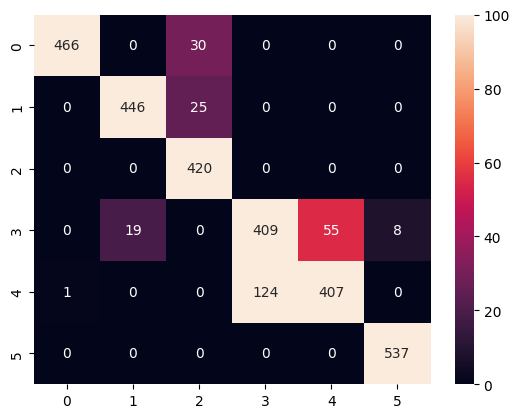

In [40]:
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)